# Model Theory 

Here we try to explain how the muscat model actually works. An in-detail analysis of each step is perfomed to explain why we do that. 

In [10]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
    """
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

# load own functions
import src.model as mus
import src.tf_generate_object as tf_go
import src.data as data
import src.zernike as zern
import src.tf_helper as tf_helper



## Setup the system 

In [16]:
# control switches
is_zernike = True

# ASsign variables from Experiment
lambda0 = .65 # free space wavelength (µm)
NAo= .95 # Numerical aperture objective
NAc= .52 # Numerical aperture condenser
NAci = 0 # Numerical aperture condenser (inner, darkfield)

# eventually decenter the illumination source - only integer!
shiftIcX = 0
shiftIcY = 0

nEmbb = 1.32
dn=.1; # nImm - nEmbb

# calculate pixelsize
dx = 0.1568
dy = 0.1568
dz = 0.1625

Nx = Ny = 31
Nz = 70
    
# Sampling coordinates
Rsim= 0.5*Nx*dx; # Radius over which simulation is performed.

Nx=np.int(np.floor((2*Rsim)/dx)+1);
Ny=np.int(np.floor((2*Rsim)/dy)+1)
mysize=np.array((Nz, Nx, Ny))

# create the first guess of the initial obj 
obj = np.ones((Nz, Nx, Ny))

# add a vector of zernike factors
nzernikes = 9
zernikefactors = np.zeros((1,nzernikes))
# kamilov uses 420 z-planes with an overall size of 30µm; dx=72nm

# refractive index immersion and embedding
lambdaM = lambda0/nEmbb; # wavelength in the medium

In [17]:
""" This computes the FWD-graph of the Q-PHASE microscope;
1.) Compute the physical dimensions
2.) Compute the sampling for the waves
3.) Create the illumination waves depending on System's properties

##### IMPORTANT! ##### 
The ordering of the channels is as follows:
    Nillu, Nz, Nx, Ny
"""

TF_obj_phase_do = tf.constant(obj, dtype=tf.float32, name='Object_const')


## Establish normalized coordinates.
#-----------------------------------------
vxx= tf_helper.xx((mysize[1], mysize[2]),'freq') * lambdaM * nEmbb / (dx * NAo);    # normalized optical coordinates in X
vyy= tf_helper.yy((mysize[1], mysize[2]),'freq') * lambdaM * nEmbb / (dy * NAo);    # normalized optical coordinates in Y

# AbbeLimit=lambda0/NAo;  # Rainer's Method
# RelFreq = rr(mysize,'freq')*AbbeLimit/dx;  # Is not generally right (dx and dy)
RelFreq = np.sqrt(tf_helper.abssqr(vxx) + tf_helper.abssqr(vyy));    # spanns the frequency grid of normalized pupil coordinates
Po=RelFreq < 1.0;   # Create the pupil of the objective lens        

# Precomputing the first 9 zernike coefficients 
myzernikes = np.zeros((Po.shape[0],Po.shape[1],nzernikes))+ 1j*np.zeros((Po.shape[0],Po.shape[1],nzernikes))
r, theta = zern.cart2pol(vxx, vyy)        
for i in range(0,nzernikes):
    myzernikes[:,:,i] = np.fft.fftshift(zern.zernike(r, theta, i+1, norm=False)) # or 8 in X-direction
    
# eventually introduce a phase factor to approximate the experimental data better
Po = np.fft.fftshift(Po)# Need to shift it before using as a low-pass filter    Po=np.ones((np.shape(Po)))
if is_zernike:
    print('----------> Be aware: We are taking aberrations into account!')
    # Assuming: System has coma along X-direction
    myaberration = np.sum(zernikefactors * myzernikes, axis=2)
    Po = 1.*Po

# Prepare the normalized spatial-frequency grid.
S = NAc/NAo;   # Coherence factor
Ic = RelFreq <= S
myIntensityFactor = 70
Ic_map = np.cos((myIntensityFactor *tf_helper.xx((Nx, Ny), mode='freq')**2+myIntensityFactor *tf_helper.yy((Nx, Ny), mode='freq')**2))**2 
Ic = Ic * Ic_map # weight the intensity in the condenser aperture, unlikely to be uniform
print('We are weighing the Intensity int the illu-pupil!')

if(False):
    if hasattr(self, 'NAci'):
        if NAci != None and NAci > 0:
            #print('I detected a darkfield illumination aperture!')
            S_o = NAc/NAo;   # Coherence factor
            S_i = NAci/NAo;   # Coherence factor
            Ic = (1.*(RelFreq < S_o) * 1.*(RelFreq > S_i))>0 # Create the pupil of the condenser plane

    # Shift the pupil in X-direction (optical missalignment)
    if hasattr(self, 'shiftIcX'):
        if shiftIcX != None:
            print('Shifting the illumination in X by: ' + str(shiftIcX) + ' Pixel')
            Ic = np.roll(Ic, shiftIcX, axis=1)

    # Shift the pupil in Y-direction (optical missalignment)
    if hasattr(self, 'shiftIcY'):
        if shiftIcY != None:
            print('Shifting the illumination in Y by: ' + str(shiftIcY) + ' Pixel')
            Ic = np.roll(Ic, shiftIcY, axis=0)

## Forward propagator  (Ewald sphere based) DO NOT USE NORMALIZED COORDINATES HERE
kxysqr= (tf_helper.abssqr(tf_helper.xx((mysize[1], mysize[2]), 'freq') / dx) + tf_helper.abssqr(
    tf_helper.yy((mysize[1], mysize[2]), 'freq') / dy)) + 0j;
k0=1/lambdaM;
kzsqr= tf_helper.abssqr(k0) - kxysqr;
kz=np.sqrt(kzsqr);
kz[kzsqr < 0]=0;
dphi = 2*np.pi*kz*dz;  # exp(1i*kz*dz) would be the propagator for one slice

## Get a list of vector coordinates corresponding to the pixels in the mask
xfreq= tf_helper.xx((mysize[1], mysize[2]),'freq');
yfreq= tf_helper.yy((mysize[1], mysize[2]),'freq');
Nc=np.sum(Ic>0); 
print('Number of Illumination Angles / Plane waves: '+str(Nc))

# Calculate the computatonal grid/sampling
kxcoord = np.reshape(xfreq[Ic>0],[1, 1, 1, Nc]);    # NA-positions in condenser aperture plane in x-direction
kycoord = np.reshape(yfreq[Ic>0],[1, 1, 1, Nc]);    # NA-positions in condenser aperture plane in y-direction
RefrCos = np.reshape(k0/kz[Ic>0],[1, 1, 1, Nc]);   # 1/cosine used for the application of the refractive index steps to acount for longer OPD in medium under an oblique illumination angle

## Generate the illumination amplitudes
intensityweights = Ic[Ic>0]
A_input = intensityweights *np.exp((2*np.pi*1j) * 
    (kxcoord * tf_helper.repmat4d(tf_helper.xx((mysize[1], mysize[2])), Nc) 
   + kycoord * tf_helper.repmat4d(tf_helper.yy((mysize[1], mysize[2])), Nc))) # Corresponds to a plane wave under many oblique illumination angles - bfxfun

## propagate field to z-stack and sum over all illumination angles
Alldphi = -np.reshape(np.arange(0, mysize[0], 1), [1, 1, mysize[0]])*np.repeat(np.fft.fftshift(dphi)[:, :, np.newaxis], mysize[0], axis=2)
 
# Ordinary backpropagation. This is NOT what we are interested in:
myAllSlicePropagator=np.transpose(np.exp(1j*Alldphi) * (np.repeat(np.fft.fftshift(dphi)[:, :, np.newaxis], mysize[0], axis=2) >0), [2, 0, 1]);  # Propagates a single end result backwards to all slices




----------> Be aware: We are taking aberrations into account!
We are weighing the Intensity int the illu-pupil!
Number of Illumination Angles / Plane waves: 49


# Display Pupils 

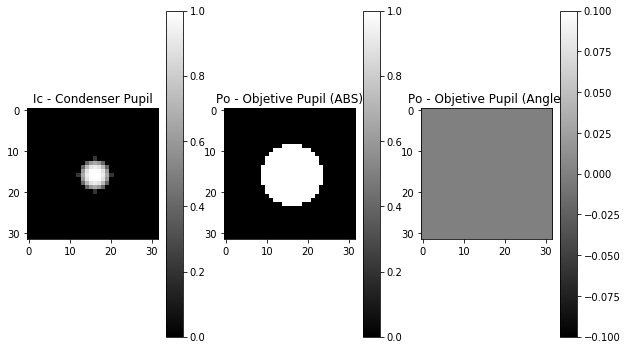

(32, 32)


In [19]:
plt.subplot(131), plt.title('Ic - Condenser Pupil'), plt.imshow(Ic), plt.colorbar()
plt.subplot(132), plt.title('Po - Objetive Pupil (ABS)'),plt.imshow(np.fft.fftshift(np.abs(Po))), plt.colorbar()
plt.subplot(133), plt.title('Po - Objetive Pupil (Angle)'),plt.imshow(np.fft.fftshift(np.angle(Po))), plt.colorbar(), plt.show()
